# Workshop #10. Working with geographical data





### PREPARATION PART BEGINS

This final project is done by **Herman Havva**

### PREPARATION PART ENDS

-----------------------------

Install libraries:

In [1]:
!pip install numpy matplotlib pandas altair 

  Using cached numpy-2.3.5-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached altair-6.0.0-py3-none-any.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.wh

## Cool project, awesome project
### The roadmap of the project 
1. Clean-up arranging the data
2. **Analysis**

#### Analysis layout (what it attempts to show)
- **Main objective:** to create a comprehensive analysis of the extensive guide, explore the following points of interest
    1. Which districts(повіти) appear to be more wealthy in comparison to others, as in Russian Empire merchanants(wealthy prople) could leave some **treasures**(скарби) for "good times", we want to explore that
    2. Also, by any chance, lets explore the ratio of men and women born and dead, may be we can find something interesting, lets find it per district
    3. 

#### Clean-up and arranging the data 
- renamed the dataframes (.csv) to have reasonable names
- extracted raw data into pandas dataframes for the future analysis

Plot generated: sleep_analysis_plot.png


/var/folders/vr/0mztxq6x39jfmjxrj1vxtb380000gn/T/ipykernel_2194/1958028303.py:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


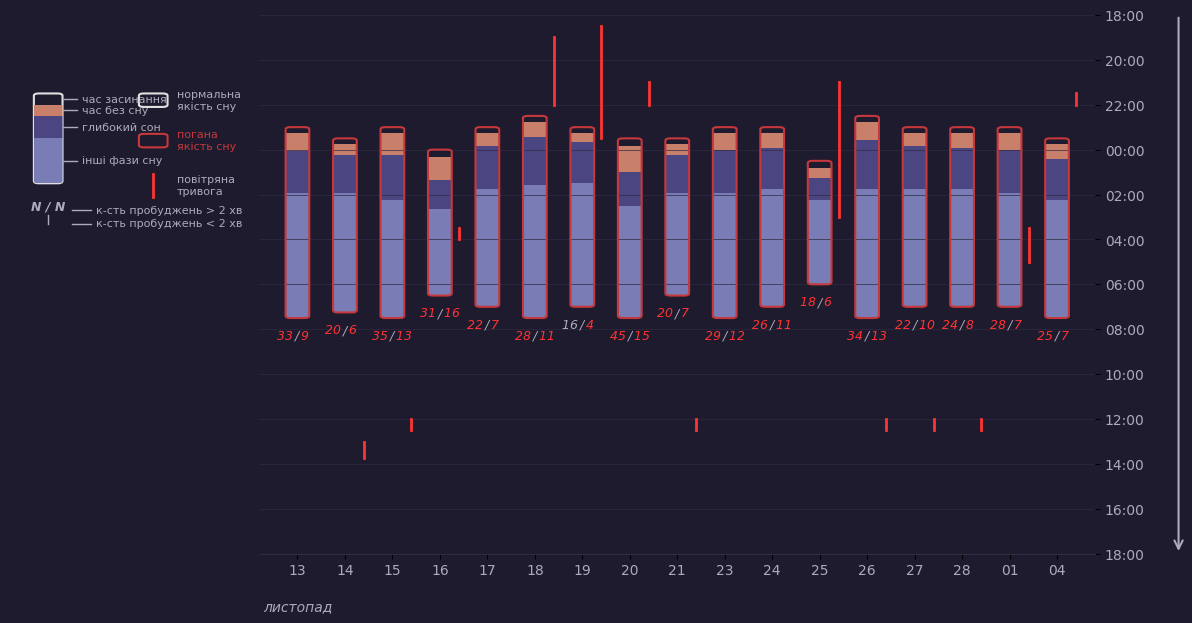

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

# --- 1. Configuration & Styling ---
STYLE = {
    'bg_color': '#1E1B2E',        # Dark purple background
    'text_color': '#AFAAB9',      # Light grey-purple for text
    'grid_color': '#2F2B42',      # Subtle grid lines
    'bar_other': '#7A7DB5',       # Light Purple (Other Stages)
    'bar_deep': '#4B4682',        # Dark Purple (Deep Sleep)
    'bar_awake': '#C8806A',       # Orange (Without Sleep)
    'bar_falling': 'none',        # Transparent for falling asleep
    'border_normal': '#E0E0E0',   # White/Grey for normal days
    'border_bad': '#C6383C',      # Red for bad sleep days
    'raid_color': '#FF3333',      # Bright red for air raids
    'annotation_alert': '#FF3333' # Red for bad stats
}

# --- 2. Helper Functions ---

def normalize_time_to_y_axis(timestamp, reference_date_str):
    """
    Converts a timestamp into hours relative to 18:00 on the reference date.
    Y-Axis 0.0 = 18:00 (Reference Date)
    Y-Axis 24.0 = 18:00 (Next Day)
    """
    ref_date = datetime.strptime(reference_date_str, '%Y-%m-%d')
    start_of_axis = ref_date.replace(hour=18, minute=0, second=0, microsecond=0)
    diff = (timestamp - start_of_axis).total_seconds() / 3600
    return diff

def is_bad_sleep(row):
    return row['without_sleep_duration'] > 30 or row['awakening_number_more_2_min'] > 3

def draw_colored_text(ax, x, y, text1, color1, separator, color_sep, text2, color2, fontsize=9):
    """Helper to draw 'Text1 / Text2' with different colors centered at x."""
    t_sep = ax.text(x, y, separator, ha='center', va='top', color=color_sep, fontsize=fontsize, fontstyle='italic')
    ax.text(x, y, text1 + " ", ha='right', va='top', color=color1, fontsize=fontsize, fontstyle='italic')
    ax.text(x, y, " " + text2, ha='left', va='top', color=color2, fontsize=fontsize, fontstyle='italic')


# --- 3. Data Loading ---

df_sleep = pd.read_csv('sleep_data.csv')
time_cols = ['bedtime_timestamp', 'wake_up_timestamp']
for col in time_cols:
    df_sleep[col] = pd.to_datetime(df_sleep[col])

df_raid = pd.read_csv('air_raid_data.csv')
raid_cols = ['air_raid_start_timestamp', 'air_raid_stop_timestamp']
for col in raid_cols:
    df_raid[col] = pd.to_datetime(df_raid[col])

# --- 4. Plotting Setup ---

# Reduced figsize width from 15 to 14, height remains 7
fig = plt.figure(figsize=(14, 7))
fig.patch.set_facecolor(STYLE['bg_color'])

# Adjusted width ratios from [1, 4.5] to [1, 3.5] to shrink the chart column by ~20%
# wspace remains small
gs = fig.add_gridspec(1, 2, width_ratios=[1, 3.5], wspace=0.02)

ax_legend = fig.add_subplot(gs[0])
ax_main = fig.add_subplot(gs[1])

# --- FIX: Z-Order and Transparency ---
# Make Legend opaque and sit on top (Z=10)
ax_legend.set_facecolor(STYLE['bg_color'])
ax_legend.set_zorder(10)

# Make Main Chart transparent (Z=1) so it doesn't visually occlude if it bleeds
ax_main.set_facecolor('none')
ax_main.set_zorder(1)


# --- 5. Configuring Main Axes (ax_main) ---

# Y-axis (Time) configuration
ax_main.set_ylim(24, 0) # 0 (18:00) at Top
# X-axis configuration (Tight fit around data)
ax_main.set_xlim(-0.8, len(df_sleep) - 0.2)

# X-axis Labels
dates = df_sleep['date'].tolist()
date_labels = [datetime.strptime(d, '%Y-%m-%d').strftime('%d') for d in dates]
ax_main.set_xticks(range(len(dates)))
ax_main.set_xticklabels(date_labels, color=STYLE['text_color'])

# Y-axis Labels (Right Side)
yticks = list(range(0, 25, 2))
ytick_labels = [f"{(18 + h) % 24:02d}:00" for h in yticks]
ax_main.set_yticks(yticks)
ax_main.set_yticklabels(ytick_labels, color=STYLE['text_color'])
ax_main.yaxis.tick_right()
ax_main.grid(True, axis='y', color=STYLE['grid_color'], linestyle='-', linewidth=0.5)

# Timeline Arrow
# Adjusted to 1.1 to ensure it clears labels with the narrower aspect ratio
ax_main.annotate('', xy=(1.1, 0), xytext=(1.1, 1), xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='->', color=STYLE['text_color'], lw=1.5, mutation_scale=15))

# Remove Spines for Main Chart
for spine in ax_main.spines.values():
    spine.set_visible(False)
ax_main.spines['bottom'].set_visible(True)
ax_main.spines['bottom'].set_color(STYLE['grid_color'])


# --- 6. Drawing Bars (on ax_main) ---

bar_width = 0.5
rounding_radius = 0.1 

for i, row in df_sleep.iterrows():
    current_date = row['date']
    
    dur_falling = row['falling_asleep_duration'] / 60
    dur_awake = row['without_sleep_duration'] / 60
    dur_deep = row['deep_sleep_duration'] / 60
    dur_other = row['other_sleep_stages_duration'] / 60
    total_height = dur_falling + dur_awake + dur_deep + dur_other
    
    y_start = normalize_time_to_y_axis(row['bedtime_timestamp'], current_date)
    
    # Border
    border_color = STYLE['border_bad'] if is_bad_sleep(row) else STYLE['border_normal']
    rounded_box = patches.FancyBboxPatch(
        (i - bar_width/2, y_start), bar_width, total_height,
        boxstyle=f"round,pad=0,rounding_size={rounding_radius}",
        linewidth=1.5, edgecolor=border_color, facecolor='none',
        zorder=10 
    )
    ax_main.add_patch(rounded_box)
    
    # Inner Segments
    # Awake
    rect_awake = patches.Rectangle(
        (i - bar_width/2, y_start + dur_falling), bar_width, dur_awake,
        facecolor=STYLE['bar_awake'], edgecolor='none'
    )
    rect_awake.set_clip_path(rounded_box)
    ax_main.add_patch(rect_awake)
    
    # Deep
    rect_deep = patches.Rectangle(
        (i - bar_width/2, y_start + dur_falling + dur_awake), bar_width, dur_deep,
        facecolor=STYLE['bar_deep'], edgecolor='none'
    )
    rect_deep.set_clip_path(rounded_box)
    ax_main.add_patch(rect_deep)
    
    # Other
    rect_other = patches.Rectangle(
        (i - bar_width/2, y_start + dur_falling + dur_awake + dur_deep), bar_width, dur_other,
        facecolor=STYLE['bar_other'], edgecolor='none'
    )
    rect_other.set_clip_path(rounded_box)
    ax_main.add_patch(rect_other)
    
    # Annotations (N / M)
    n_less = row['awakening_number_less_2_min']
    n_more = row['awakening_number_more_2_min']
    c_less = STYLE['annotation_alert'] if n_less > 17 else STYLE['text_color']
    c_more = STYLE['annotation_alert'] if n_more > 2 else STYLE['text_color']
    
    y_bottom = y_start + total_height + 0.5
    draw_colored_text(ax_main, i, y_bottom, str(n_less), c_less, "/", STYLE['text_color'], str(n_more), c_more)

# Drawing Air Raids (on ax_main)
for i, row in df_sleep.iterrows():
    current_date_obj = datetime.strptime(row['date'], '%Y-%m-%d')
    next_date_obj = current_date_obj + timedelta(days=1)
    window_start = current_date_obj.replace(hour=18, minute=0)
    window_end = next_date_obj.replace(hour=18, minute=0)
    
    relevant_raids = df_raid[
        (df_raid['air_raid_start_timestamp'] >= window_start) & 
        (df_raid['air_raid_start_timestamp'] < window_end)
    ]
    
    for _, raid in relevant_raids.iterrows():
        y_start = normalize_time_to_y_axis(raid['air_raid_start_timestamp'], row['date'])
        y_end = normalize_time_to_y_axis(raid['air_raid_stop_timestamp'], row['date'])
        
        x_pos = i + 0.4 
        ax_main.plot([x_pos, x_pos], [y_start, y_end], color=STYLE['raid_color'], linewidth=2)


# --- 7. Configuring Legend Axes (ax_legend) ---

# We set the same Y-limits to match the height scale of the main chart
ax_legend.set_ylim(24, 0)
ax_legend.set_xlim(0, 5) # Arbitrary width unit for layout
ax_legend.axis('off') # Hide all axis lines/ticks

# Coordinates for legend items (in ax_legend data units)
lx = 0.5 
ly_start = 3.5 # Shifted down further to create top space

# 7.1 Sample Bar (Reduced dimensions)
sample_width = 0.6 
sample_height = 4.0 
l_box = patches.FancyBboxPatch(
    (lx, ly_start), sample_width, sample_height,
    boxstyle=f"round,pad=0,rounding_size={rounding_radius}",
    linewidth=1.5, edgecolor=STYLE['border_normal'], facecolor='none'
)
ax_legend.add_patch(l_box)

# Fill sample
# Scaled heights: (0.5, 0.5, 1.0, 2.0) = 4.0 total
h1, h2, h3, h4 = 0.5, 0.5, 1.0, 2.0
r_awake = patches.Rectangle((lx, ly_start + h1), sample_width, h2, facecolor=STYLE['bar_awake'])
r_awake.set_clip_path(l_box)
ax_legend.add_patch(r_awake)

r_deep = patches.Rectangle((lx, ly_start + h1 + h2), sample_width, h3, facecolor=STYLE['bar_deep'])
r_deep.set_clip_path(l_box)
ax_legend.add_patch(r_deep)

r_other = patches.Rectangle((lx, ly_start + h1 + h2 + h3), sample_width, h4, facecolor=STYLE['bar_other'])
r_other.set_clip_path(l_box)
ax_legend.add_patch(r_other)

# 7.2 Legend Labels
# Reduced font size to 8
def leg_label(y_bar, text):
    ax_legend.plot([lx + sample_width, lx + sample_width + 0.3], [y_bar, y_bar], color=STYLE['text_color'], lw=1)
    ax_legend.text(lx + sample_width + 0.4, y_bar, text, va='center', color=STYLE['text_color'], fontsize=8)

leg_label(ly_start + h1/2, "час засинання")
leg_label(ly_start + h1 + h2/2, "час без сну")
leg_label(ly_start + h1 + h2 + h3/2, "глибокий сон")
leg_label(ly_start + h1 + h2 + h3 + h4/2, "інші фази сну")

# 7.3 Stats Legend
# Increased spacing below the sample bar
stats_y_start = ly_start + sample_height + 1.2
ax_legend.text(lx + sample_width/2, stats_y_start, "N / N", 
        ha='center', color=STYLE['text_color'], fontsize=9, fontstyle='italic', weight='bold')

ax_legend.plot([lx + sample_width + 0.2, lx + sample_width + 0.6], 
        [stats_y_start, stats_y_start], color=STYLE['text_color'], lw=1)
ax_legend.text(lx + sample_width + 0.7, stats_y_start, "к-сть пробуджень > 2 хв", va='center', color=STYLE['text_color'], fontsize=8)

ax_legend.plot([lx + sample_width + 0.2, lx + sample_width + 0.6], 
        [stats_y_start + 0.6, stats_y_start + 0.6], color=STYLE['text_color'], lw=1)
ax_legend.plot([lx + sample_width/2, lx + sample_width/2], 
        [stats_y_start + 0.2, stats_y_start + 0.6], color=STYLE['text_color'], lw=1)
ax_legend.text(lx + sample_width + 0.7, stats_y_start + 0.6, "к-сть пробуджень < 2 хв", va='center', color=STYLE['text_color'], fontsize=8)

# 7.4 Quality Boxes
# Shifted closer to the left (lx + 2.2) and reduced size (0.6x0.6)
bx = lx + 2.2 
by = ly_start

b_norm = patches.FancyBboxPatch((bx, by), 0.6, 0.6, boxstyle="round,pad=0,rounding_size=0.1", 
                                edgecolor=STYLE['border_normal'], facecolor='none', lw=1.5)
ax_legend.add_patch(b_norm)
ax_legend.text(bx + 0.8, by + 0.3, "нормальна\nякість сну", va='center', color=STYLE['text_color'], fontsize=8)

# Increased vertical spacing for quality boxes
by2 = by + 1.8
b_bad = patches.FancyBboxPatch((bx, by2), 0.6, 0.6, boxstyle="round,pad=0,rounding_size=0.1", 
                               edgecolor=STYLE['border_bad'], facecolor='none', lw=1.5)
ax_legend.add_patch(b_bad)
ax_legend.text(bx + 0.8, by2 + 0.3, "погана\nякість сну", va='center', color=STYLE['border_bad'], fontsize=8)

by3 = by2 + 1.8
ax_legend.plot([bx + 0.3, bx + 0.3], [by3, by3 + 1.0], color=STYLE['raid_color'], lw=2)
ax_legend.text(bx + 0.8, by3 + 0.5, "повітряна\nтривога", va='center', color=STYLE['text_color'], fontsize=8)


# Title & Layout
# Removing main title and adding localized footer label
# plt.suptitle("Sleep Analysis (Листопад)", color=STYLE['text_color'], fontsize=16, y=0.95)
ax_main.text(0, 26.5, "листопад", color=STYLE['text_color'], fontsize=10, ha='center', fontstyle='italic')

plt.tight_layout()
plt.savefig('sleep_analysis_plot.png', facecolor=STYLE['bg_color'])
print("Plot generated: sleep_analysis_plot.png")